<a href="https://colab.research.google.com/github/krisograbek/nlp-sarcasm/blob/main/NLPTextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Main goal - NLP Project

TODO:

1. Getting the data
 - Read Data
 - Create a Data Frame
2. Exploratory Data Analysis
 - Show missing values
 - Class Distribution
 - Character length (by class)
 - Number of words
 - Average word length
3. Creating corpus for each class
 - common stopwords
 - punctuation
 - most common words
 - ngrams (most common)
5. Splitting to train and test data
6. Experimenting
  Here's where I want to start experimenting. Different cleaning methods, n_grams, etc
 - Apply Comet
7. Cleaning data. What do I want to clean? What should I?
8. Splitting to 5 Stratified kfolds
8. Creating Bag Of Words
9. Creating TF-IDF


### Installs and imports

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ograbekk","key":"b46693621f0a1b3e85616c1d2e14e503"}'}

In [ ]:
# create a dir for kaggle API
! mkdir ~/.kaggle
# copy the json file with API Key
! cp kaggle.json ~/.kaggle
# make it read-only
! chmod 600 ~/.kaggle/kaggle.json

### Download Data

In [ ]:
! kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection --unzip

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 111MB/s]


### Unzip Data

In [ ]:
# !unzip /content/news-headlines-dataset-for-sarcasm-detection.zip

## Imports

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()

### Read Data

In [ ]:
import json

def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data = list(parse_data('./Sarcasm_Headlines_Dataset_v2.json'))

### Create Data Frame

In [ ]:
df = pd.DataFrame.from_records(data)

## Basic EDA

In [ ]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


No missing values

### Class distribution

In [ ]:
dist = df.is_sarcastic.value_counts()
print(f"Totals")
print(f"Not sarcastic: {dist[0]}")
print(f"Sarcastic: {dist[1]}")

dist_norm = df.is_sarcastic.value_counts(normalize=True)
print(f"Percentage")
print(f"Not sarcastic: {dist_norm[0]}")
print(f"Sarcastic: {dist_norm[1]}")

Totals
Not sarcastic: 14985
Sarcastic: 13634
Percentage
Not sarcastic: 0.523603200670883
Sarcastic: 0.476396799329117


Text(0, 0.5, 'samples')

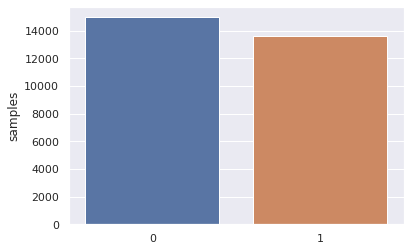

In [ ]:
x = df.is_sarcastic.value_counts()
sns.barplot(x = x.index,y = x)
plt.gca().set_ylabel('samples')

### Number of characters

In [ ]:
df.loc[:, "char_len"] = df.headline.apply(lambda x: len(x))
df.head()

,is_sarcastic,headline,article_link,char_len
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,61
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,79
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,49
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,52
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,61


In [ ]:
sarc = df[df.is_sarcastic == 1]
no_sarc = df[df.is_sarcastic == 0]

In [ ]:
def plot_hists(data, col_name, bins):
    # selecting a palette with a generator
    palette = iter(sns.husl_palette(3, s=0.8))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
    ax1.hist(data[col_name], color=next(palette), bins=bins);
    ax1.set_title("All headlines")

    ax2.hist(data[data.is_sarcastic == 0][col_name], color=next(palette), bins=bins);
    ax2.set_title("Not sarcastic")

    ax3.hist(data[data.is_sarcastic == 1][col_name], color=next(palette), bins=bins);
    ax3.set_title("Sarcastic")

def plot_displots(data, col_name):
    # selecting a palette with a generator
    palette = iter(sns.husl_palette(3, s=0.8))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
    sns.histplot(data=data[col_name], ax=ax1, color=next(palette), kde=True);
    ax1.set_title("All headlines")

    sns.histplot(data=data[data.is_sarcastic == 0][col_name], ax=ax2, color=next(palette), kde=True);
    ax2.set_title("Not sarcastic")

    sns.histplot(data=data[data.is_sarcastic == 1][col_name], ax=ax3, color=next(palette), kde=True);
    ax3.set_title("Sarcastic")

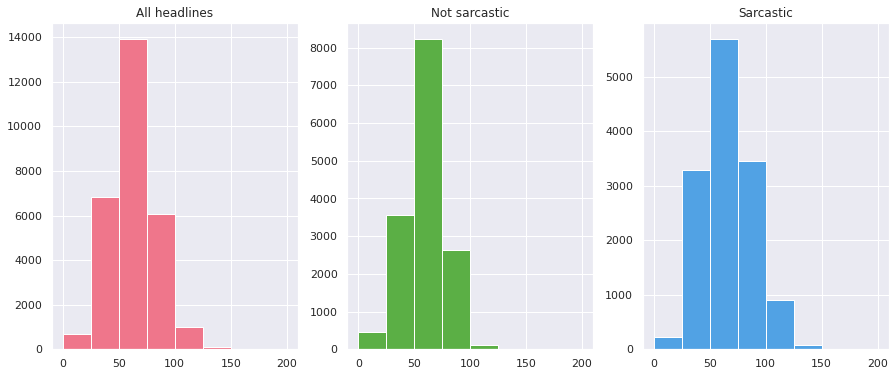

In [ ]:
chars_bins = np.linspace(0, 200, 9)

plot_hists(df, "char_len", chars_bins)

In [ ]:
df.char_len.value_counts(bins=[0, 50, 100, 150, 200, 10000])

(50.0, 100.0]       19622
(-0.001, 50.0]       7990
(100.0, 150.0]        993
(150.0, 200.0]          8
(200.0, 10000.0]        6
Name: char_len, dtype: int64

In [ ]:
# Not sarcastic
no_sarc.char_len.value_counts(bins=[0, 50, 75, 100, 150, 200, 10000])

(50.0, 75.0]        8267
(-0.001, 50.0]      4256
(75.0, 100.0]       2356
(100.0, 150.0]       103
(150.0, 200.0]         2
(200.0, 10000.0]       1
Name: char_len, dtype: int64

In [ ]:
# Not sarcastic
no_sarc.char_len.value_counts(bins=[0, 50, 75, 100, 150, 200, 10000], normalize=True)

(50.0, 75.0]        0.551685
(-0.001, 50.0]      0.284017
(75.0, 100.0]       0.157224
(100.0, 150.0]      0.006874
(150.0, 200.0]      0.000133
(200.0, 10000.0]    0.000067
Name: char_len, dtype: float64

In [ ]:
# Not sarcastic
no_sarc.char_len.value_counts(bins=[0, 100, 1000 ], normalize=True)

(-0.001, 100.0]    0.992926
(100.0, 1000.0]    0.007074
Name: char_len, dtype: float64

Only 0.7% of not sarcastic headlines have more than 100 characters

In [ ]:
# Sarcastic
sarc.char_len.value_counts(bins=[0, 50, 75, 100, 150, 200, 10000])

(50.0, 75.0]        5658
(-0.001, 50.0]      3734
(75.0, 100.0]       3341
(100.0, 150.0]       890
(150.0, 200.0]         6
(200.0, 10000.0]       5
Name: char_len, dtype: int64

In [ ]:
# Sarcastic
sarc.char_len.value_counts(bins=[0, 50, 75, 100, 150, 200, 10000], normalize=True)

(50.0, 75.0]        0.414992
(-0.001, 50.0]      0.273874
(75.0, 100.0]       0.245049
(100.0, 150.0]      0.065278
(150.0, 200.0]      0.000440
(200.0, 10000.0]    0.000367
Name: char_len, dtype: float64

In [ ]:
# Sarcastic
sarc.char_len.value_counts(bins=[0, 100, 1000 ], normalize=True)

(-0.001, 100.0]    0.933915
(100.0, 1000.0]    0.066085
Name: char_len, dtype: float64

Over 6.6% of sarcastic headlines have more than 100 characters

In [ ]:
# All
# df.char_len.value_counts().loc[lambda x: x>200]

In [ ]:
# df = df.loc[df.char_len < 200]
# df.char_len.value_counts(bins=[0, 50, 100, 150, 200, 10000])

### Number of words in a tweet

In [ ]:
df.loc[:, "tokens_count"] = df.headline.apply(lambda x: len([token for token in x.split()]))
df.head()

,is_sarcastic,headline,article_link,char_len,tokens_count
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,61,8
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,79,13
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,49,7
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,52,8
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,61,9


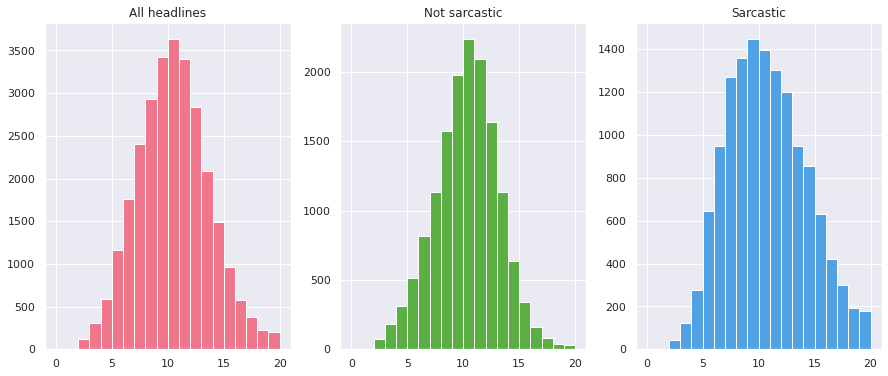

In [ ]:
tokens_bins = np.linspace(0, 20, 21)
plot_hists(df, "tokens_count", tokens_bins)

Both classes are normally distributed. Sarcastic headlines' distribution is wider [How can I describe this better / more]

In [ ]:
token_count_bins = np.linspace(0, 20, 11)
df.tokens_count.value_counts(bins=token_count_bins)

(8.0, 10.0]      7063
(10.0, 12.0]     6237
(6.0, 8.0]       5339
(12.0, 14.0]     3575
(4.0, 6.0]       2926
(14.0, 16.0]     1547
(2.0, 4.0]        897
(16.0, 18.0]      611
(18.0, 20.0]      206
(-0.001, 2.0]     118
Name: tokens_count, dtype: int64

In [ ]:
no_sarc.tokens_count.value_counts(bins=token_count_bins)

(8.0, 10.0]      4215
(10.0, 12.0]     3732
(6.0, 8.0]       2704
(12.0, 14.0]     1769
(4.0, 6.0]       1331
(2.0, 4.0]        498
(14.0, 16.0]      497
(16.0, 18.0]      120
(-0.001, 2.0]      73
(18.0, 20.0]       28
Name: tokens_count, dtype: int64

In [ ]:
no_sarc.tokens_count.value_counts(bins=token_count_bins, normalize=True)

(8.0, 10.0]      0.281281
(10.0, 12.0]     0.249049
(6.0, 8.0]       0.180447
(12.0, 14.0]     0.118051
(4.0, 6.0]       0.088822
(2.0, 4.0]       0.033233
(14.0, 16.0]     0.033166
(16.0, 18.0]     0.008008
(-0.001, 2.0]    0.004872
(18.0, 20.0]     0.001869
Name: tokens_count, dtype: float64

In [ ]:
no_sarc.tokens_count.value_counts(bins=np.linspace(0, 20, 6), normalize=True)

(8.0, 12.0]      0.530330
(4.0, 8.0]       0.269269
(12.0, 16.0]     0.151218
(-0.001, 4.0]    0.038105
(16.0, 20.0]     0.009877
Name: tokens_count, dtype: float64

In [ ]:
sarc.tokens_count.value_counts(bins=token_count_bins)

(8.0, 10.0]      2848
(6.0, 8.0]       2635
(10.0, 12.0]     2505
(12.0, 14.0]     1806
(4.0, 6.0]       1595
(14.0, 16.0]     1050
(16.0, 18.0]      491
(2.0, 4.0]        399
(18.0, 20.0]      178
(-0.001, 2.0]      45
Name: tokens_count, dtype: int64

In [ ]:
sarc.tokens_count.value_counts(bins=token_count_bins, normalize=True)

(8.0, 10.0]      0.208890
(6.0, 8.0]       0.193267
(10.0, 12.0]     0.183732
(12.0, 14.0]     0.132463
(4.0, 6.0]       0.116987
(14.0, 16.0]     0.077013
(16.0, 18.0]     0.036013
(2.0, 4.0]       0.029265
(18.0, 20.0]     0.013056
(-0.001, 2.0]    0.003301
Name: tokens_count, dtype: float64

In [ ]:
sarc.tokens_count.value_counts(bins=np.linspace(0, 20, 6), normalize=True)

(8.0, 12.0]      0.392621
(4.0, 8.0]       0.310254
(12.0, 16.0]     0.209476
(16.0, 20.0]     0.049069
(-0.001, 4.0]    0.032566
Name: tokens_count, dtype: float64

Over 53% of all not sarcastic headlines has between 8 and 12 words. For sarcastic headlines this number is less than 40%

### Average word length

In [ ]:
def get_avg_len(text):
    token_sizes = [len(word) for word in text.split()]
    return np.mean(np.array(token_sizes))


In [ ]:
df.loc[:, "avg_word_len"] = df.headline.apply(get_avg_len)

In [ ]:
df.head()

,is_sarcastic,headline,article_link,char_len,tokens_count,avg_word_len
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,61,8,6.750000
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,79,13,5.153846
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,49,7,6.142857
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,52,8,5.625000
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,61,9,5.888889


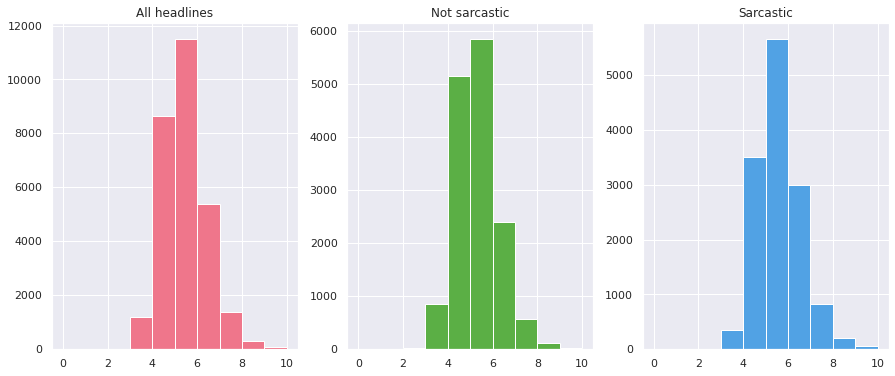

In [ ]:
avg_len_bins = np.linspace(0, 10, 11)
plot_hists(df, "avg_word_len", avg_len_bins)

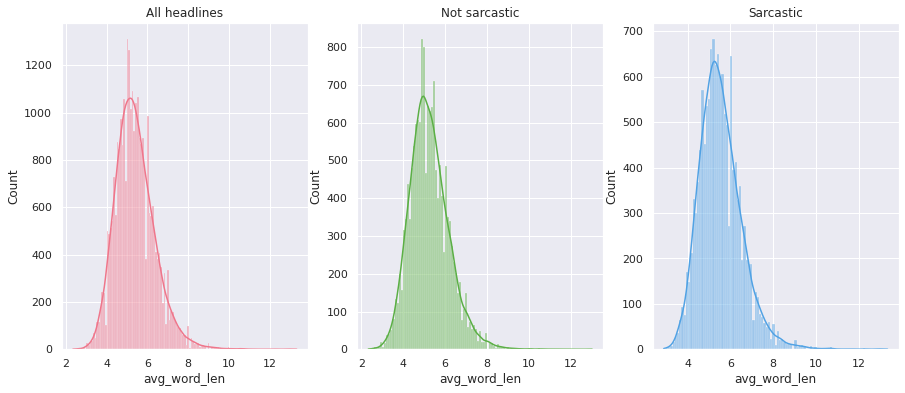

In [ ]:
plot_displots(df, "avg_word_len")

It's more likely that a sarcastic headline has an average word lenght longer higher than 6

## Corpus analysis

 - common stopwords
 - common punctuation
 - common words
 - common ngrams


## Training

### Bag Of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold

In [ ]:
df["kfold"] = -1

y = df.is_sarcastic.values

In [ ]:
# init kfold instance
kfold = StratifiedKFold(shuffle=True, random_state=42)
for fold_, (train_rows, test_rows) in enumerate(kfold.split(X=df, y=y)):
    df.loc[test_rows, "kfold"] = fold_

In [ ]:
df.head()

,is_sarcastic,headline,article_link,char_len,tokens_count,avg_word_len,kfold
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,61,8,6.750000,3
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,79,13,5.153846,2
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,49,7,6.142857,4
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,52,8,5.625000,2
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,61,9,5.888889,1


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
for fold_ in range(5):
    df_train = df[df.kfold != fold_].reset_index(drop=True)
    df_test = df[df.kfold == fold_].reset_index(drop=True)

    count_vec = CountVectorizer()
    count_vec.fit(df_train.headline)

    xtrain = count_vec.transform(df_train.headline)
    xtest = count_vec.transform(df_test.headline)

    # lr = LogisticRegression()
    # lr.fit(xtrain, df_train.is_sarcastic)

    rf = RandomForestClassifier()
    rf.fit(xtrain, df_train.is_sarcastic)

    preds = rf.predict(xtest)

    # print(preds)

    acc = accuracy_score(df_test.is_sarcastic, preds)

    print(f"Fold: {fold_}")
    print(f"Accuracy: {acc}")


Fold: 0
Accuracy: 0.8144654088050315
Fold: 1
Accuracy: 0.8031097134870719
Fold: 2
Accuracy: 0.8162124388539483
Fold: 3
Accuracy: 0.8151642208245982
Fold: 4
Accuracy: 0.8107635855320636


In [ ]:
df.is_sarcastic

0        1
1        0
2        0
3        1
4        1
        ..
28614    1
28615    1
28616    0
28617    1
28618    1
Name: is_sarcastic, Length: 28619, dtype: int64